------------------------------------------------------------------------------
# **MAIN DATASET: NYPD COMPLAINTS (Historic)**
------------------------------------------------------------------------------

1. Gautam Patil
2. Jayraj Pamnani
3. Tanaya Patil

------------------------------------------------------------------------------
# **PART - 1 : Working on main dataset**
------------------------------------------------------------------------------

## a. To get the required columns, use this module:

1.   get_area_of_interest(df_spark, interested_columns)


## b. Data Preprocessing


###    a. Scaled peprocessing pipeline: Pass your data through these functions (if using other datasets and if your columns fall in those categories)

1.   valid_date_check(date)
2.   valid_time_check(time)
3.   reverse_geo_code_boros(df_spark, Latitude, Longitude, Boro, lat_index, long_index)
4.   refine_age_group_race(df_spark, victim_age_group=None, suspect_age_group=None, suspect_race=None, victim_race=None)
5.   refine_sex_gender_impute(df_spark, suspect_age=None, suspect_gender=None, victim_age=None, victim_gender=None)
6.   refine_precinct_jur(df_spark, precinct=None, Jur_code=None)

###.   b. Preprocessing modules curated in this notebook which are not associated with scaled preprocessing:

1. level_of_offense_check()
2. KY_CD_Check()
3. hpsa_check()
4. prem_check()
5. pd_cd_check()

## c. Data Visualization

To bring out insights after data profiling

## d. Save the cleaned data

------------------------------------------------------------------------------
# **PART - 2: Working on other datasets**
------------------------------------------------------------------------------

## Instructions for running notebooks with different datasets:

I. Import dataset. (Links are given below)


1. NYPD vehicle collision data
https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Crashes/h9gi-nx95

2. NYPD Attests Data
https://data.cityofnewyork.us/Public-Safety/NYPD-Arrests-Data-Historic-/8h9b-rp9u

3. NYPD Shooting Incident Data
https://data.cityofnewyork.us/Public-Safety/NYPD-Shooting-Incident-Data-Historic-/833y-fsy8

4. NYPD Criminal Court Summons Data
https://data.cityofnewyork.us/Public-Safety/NYPD-Criminal-Court-Summons-Historic-/sv2w-rv3k

5. NYPD Summons Historic Data
https://data.cityofnewyork.us/Public-Safety/NYPD-B-Summons-Historic-/bme5-7ty4

6. NYPD Service Calls Data
https://data.cityofnewyork.us/Public-Safety/NYPD-Calls-for-Service-Historic-/d6zx-ckhd

7. NYPD Incident Data
https://data.cityofnewyork.us/Public-Safety/NYPD-Use-of-Force-Incidents/f4tj-796d

8. Incidents Responded Data
https://data.cityofnewyork.us/Public-Safety/Incidents-Responded-to-by-Fire-Companies/tm6d-hbzd

9. Emergency Response Incidents
https://data.cityofnewyork.us/Public-Safety/Emergency-Response-Incidents/pasr-j7fb

10. Rodent Inspection Data
https://data.cityofnewyork.us/Health/Rodent-Inspection/p937-wjvj


II. Select the columns of interest from the datasets.

III. Use the modules to preprocess the dataset as required

IV. Save the datasets to CSV files

In [ ]:
!pip install pyspark
!pip install openclean
!pip install geopandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.4/149.4 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.1/267.1 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.8/260.8 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.8/109.8 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 356.9/356.9 kB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.3/227.3 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 525.6/525.6 kB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 38.9 MB/s eta 0:00:00
  Created wheel for datasize: filename=datasize-1.0.0-py2.py3-none-any.whl size=155030 sha256=a074ed83a682a2ccce97b535a0d67f81c391425d164293f8b79affaa

In [ ]:
# PySpark Setup
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession, Row
from pyspark.sql.functions import udf, struct, year, to_date, trim, col, regexp_extract
from pyspark.sql.types import StringType
from pyspark.sql.functions import when

# General Utilities
import os
import time
import warnings
import re
import random
import datetime

# Data Handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
%matplotlib inline

# Geospatial
import geopandas as gpd
from shapely import wkt
from shapely.geometry import Point, Polygon
import importlib
import shapely.geometry
importlib.reload(shapely.geometry)  # Ensures clean Point class import
from shapely.geometry import Point

# Data Cleaning & Profiling
from openclean.pipeline import stream
from openclean.profiling.column import DefaultColumnProfiler
from openclean.data.source.socrata import Socrata
from openclean.function.eval.datatype import IsDatetime

# Notebook Display
from IPython import display

# ML & Stats
import scipy as sp
from scipy.spatial.distance import cdist
import scipy.cluster.hierarchy as shc
import sklearn

In [ ]:
from geopy.geocoders import ArcGIS
geocoder=ArcGIS()
#example:
geocoder.reverse('40.61157006600007, -73.74736517199995')

Location(808 Redfern Ave, Far Rockaway, New York 11691, USA, (40.611614718328, -73.747382377557, 0.0))

In [ ]:
#Creating Spark Session
sc = SparkContext.getOrCreate();
spark = SparkSession(sc)

In [ ]:
#Downloading file from NYC Open Data
fn_src = 'https://data.cityofnewyork.us/api/views/qgea-i56i/rows.csv?accessType=DOWNLOAD'
fn_dst = '/content/NYPD_Complaint_Data_Historic.csv'

#https://data.cityofnewyork.us/resource/h9gi-nx95.csv

from six.moves import urllib

if os.path.isfile(fn_dst):
    print('File has already been downloaded', fn_dst)
else:
    print('Fetching file. This may take a while...', fn_dst)
    urllib.request.urlretrieve(fn_src, fn_dst)
    print('File has been downloaded', fn_dst)

Fetching file. This may take a while... /content/NYPD_Complaint_Data_Historic.csv
File has been downloaded /content/NYPD_Complaint_Data_Historic.csv


In [ ]:
#similarly, lets get them into pyspark rdd
def get_area_of_interest(df_spark, interested_columns):
  df_spark=df_spark.select(interested_columns)
  return df_spark

# 2. Module for date related columns

As the dataset is for the data from 2006 to 2025, we can see that there is data from unknown format of "1010-05-14" to the year 2025. We need to clean this. Over here, we remove the null values where the complaint date is <2006.

In [ ]:
import datetime
def valid_date_check(date, format):
  if isinstance(date, datetime.datetime):
    date=str(date.date())
  if date==None or date==" " or date=="":
      return False
  else:
    date_cpy=date
    split_date=date.split("-")
    format_date=format.split("-")
    if len(split_date)!=3 and len(format_date)!=3:
      date=date.split("/")
      format=format.split("/")
    else:
      date=split_date
      format=format_date
    if len(date)!=3:
      return False
    try:
      year=int(date[format.index('yyyy')])
      month=int(date[format.index('mm')])
      day=int(date[format.index('dd')])
      if year>=2006 and year<=2025:
        try:
          refined_date=datetime.datetime(year, month, day)
          return True
        except:
          return False
      else:
        return False
    except:
      return False

# 3. Module for time related columns

Similarly, lets check for the time as well. Here we must have time between
the standard 24 hours.

In [ ]:
#Deleting invalid time
def valid_time_check(time):
  if time==None or time==" " or time=="":
    return False
  else :
    cpy_time=time
    time=time.split(":")
    try:
      hour=int(time[0])
      mins=int(time[1])
      secs= int(time[2])
      # if hours is 24 then change it to 0 hours
      if hour == 24 and mins== 0 and secs == 0:
        hour=0
      try:
        newTime= datetime.time(hour,mins,secs)
        return True
      except :
        return False
    except:
      return False

#4. Module for Age Group columns
The module works for only those columns whose column names are passed

In [ ]:
def refine_age_group_race(df_spark, victim_age_group=None, suspect_age_group=None, suspect_race=None, victim_race=None):
  #params: dataframe, col names for the respective age, gender cols
  if victim_age_group:
    df_spark = df_spark.na.fill("UNKNOWN",subset=[victim_age_group])
  if suspect_age_group:
    df_spark = df_spark.na.fill("UNKNOWN",subset=[suspect_age_group])
  if suspect_race:
    df_spark = df_spark.na.fill("UNKNOWN",subset=[suspect_race])
  if victim_race:
    df_spark = df_spark.na.fill("UNKNOWN",subset=[victim_race])
  return df_spark

## 4.2 Level of offense validation

In [ ]:
#offense should belong to one of the categories- 'FELONY',"MISDEMEANOR","VIOLATION"
def level_of_offence_check(offence):
    if offence=="" or offence==" " or offence==None:
        return False
    else:
        crimes_list=['FELONY',"MISDEMEANOR","VIOLATION"]
        if offence not in crimes_list:
            return False
        else :
            return True

# 4.3 KY_CD, Housing PSA, Premises, PD_CD, PATROL_BORO cleaning

In [ ]:
def KY_CD_Check(ky_cd):
    if ky_cd=="" or ky_cd==" " or ky_cd==None:
        return False
    else:
        return True

def hpsa_check(hpsa):
    if hpsa=="" or hpsa==" " or hpsa==None:
        return False
    else:
        return True

def prem_check(pm_type):
    if pm_type=="" or pm_type==" " or pm_type==None:
        return False
    else:
        return True

def pd_cd_check(pd_cd):
    if pd_cd=="" or pd_cd==" " or pd_cd==None:
        return False
    else:
        return True

# 5. Module for Gender, Race Columns for suspects and victims

The module works for only those columns whose column names are passed

In [ ]:
def refine_sex_gender_impute(df_spark, suspect_age=None, suspect_gender=None, victim_age=None, victim_gender=None):
  #params: dataframe, col names for the respective age, gender cols

  if suspect_age:
    df_spark=df_spark.na.fill("U",subset=[suspect_age])
  if victim_age:
    df_spark=df_spark.na.fill("U",subset=[victim_age])
  if suspect_gender:
    df_spark = df_spark.na.fill("UNKNOWN",subset=[suspect_gender])
  if victim_gender:
    df_spark = df_spark.na.fill("UNKNOWN",subset=[victim_gender])
  return df_spark

# 6.a: Module for Precinct, Jurisdiction Code:
  dropping the null values

  The module works for only those columns whose column names are passed along with the df

In [ ]:
def valid_precinct_check(precinct):
  if precinct==None or precinct==" " or precinct=="":
    return False
  else :
    return True

def valid_jur_check(jur):
  if jur==None or jur==" " or jur=="":
    return False
  else :
    return True

# 6.b Module for Reverse Geocoding the boroughs using latitudes and longitudes.
1. First we will remove the rows where latitude, longitude and boroughs are null. (around 450 tuples removed)
2. Then, where the boroughs are empty, take the latitude and longitude value and reverse geocode it using the module "reverseGeocoder".
3. Impute the borough name retrived in the empty space.

So, lets remove the rows where latitudes and longitudes are NULL. After that, we can take only those rows where BORO_NM is Null. So, we have 5000 points of BORO_NM to impute using latitudes and longitudes. These are the rows where BORO_NM is null

### USING MASTER DATASET
In the case of geocoding, geocoder gives us the zipcodes based on the latitude and longitude values. Inturn, we can use the master dataset of zipcodes inorder to retrive the borough names


NOTE: The dataset can be downloaded from : https://data.beta.nyc/en/dataset/pediacities-nyc-neighborhoods/resource/7caac650-d082-4aea-9f9b-3681d568e8a5


#### NOTES:
We stored the zip codes and their corresponding borough names in the dictionary "zip_master" in the form of a look-up because, it takes O(1) time to retrive borough names hence reduces parse time.

So, we had the dataframe (boro_cleaner) where there were null values in BORO_NM column derived from the main dataframe (df_temp_boro_clean). Now we merge back the imputed dataframe back to the main dataframe.

In [ ]:
#Checking the validity of coordinates
class Point:
    def __init__(self,x,y):
        self.x = x
        self.y = y

#Bounding Box Lat details for NYC
lat_max=40.917577
lat_min=40.477399
long_max=-73.700009
long_min=-74.25909

#Function to check validity of Lat values
def to_check_long(x):
  try:
    if x== "" or x== " "or x==None:
      return False
    elif (long_min<x) and (x<long_max):
      return True
    else:
      return False
  except ValueError:
    return False

#Function to check validity of Lat values
def to_check_lat(x):
  try:
    if x== "" or x== " "or x==None:
      return False
    elif (lat_min<x) and (x<lat_max):
      return True
    else:
      return False
  except ValueError:
    return False

In [ ]:
def reverse_geo_code_boros(df_spark, Latitude, Longitude, Boro, lat_index, long_index):
  #select data where we have to impute
  df_temp_boro_clean=df_spark.filter((df_spark[Latitude].isNotNull()) & (df_spark[Longitude].isNotNull()))
  boro_cleaner=df_temp_boro_clean.filter((df_temp_boro_clean[Boro].isNull())|(df_temp_boro_clean[Boro]=='NEW YORK'))

  # print("We have "+ str(boro_cleaner.count())+ " points to impute")
  print("___intializing Zip Code Look up ____")
  print("____ imputing the points ____")


  #use your path for master dataset here.
  df_zips=pd.read_csv(dst)
  zip_master={}
  zips=df_zips['zip']
  boro=df_zips['borough']
  for i, j in zip(zips, boro):
    zip_master[i]=j
  zip_master[10020]='Manhattan'
  zip_master[11249]='Brooklyn'

  def reverseGeoCoder(latitude, longitude):
    loc=geocoder.reverse(str(latitude)+', '+str(longitude), timeout=1000)
    zipCode=str(loc).split(",")[2][-5:]
    if not int(zipCode) in zip_master:
      boro="UNKNOWN"
    else:
      boro=zip_master[int(zipCode)]
    boro=boro.upper()
    return boro

  #creating UD function
  ud_func= udf(reverseGeoCoder, StringType())
  boro_cleaned_dataframe = boro_cleaner.withColumn(Boro, ud_func(boro_cleaner[lat_index], boro_cleaner[long_index]))

  #joining the imputed dataset to the maindataset and returning

  joiner_dataset=df_spark.filter((df_spark[Latitude].isNotNull()) & (df_spark[Boro]!='NEW YORK') & (df_spark[Longitude].isNotNull()) & (df_spark[Boro].isNotNull()))
  fin_df=joiner_dataset.union(boro_cleaned_dataframe)
  return fin_df

Just for the testing purpose, we can choose the sample subset to work on.

The size of dataset ~ 9.5M tuples. So, we need around 900000 data points for 99% confidence level with 1% interval. The size of data is almost 1% of the data. So we can get it into our df now

#### ** *NOTE: TO RUN THE PIPELINE OVER ALL THE TUPLES, JUST COMMENT THE SECOND LINE IN THE BELOW CODE MODULE* **

In [ ]:
df_spark=spark.read.option("header",True).csv(fn_dst,inferSchema=True)
#comment the below line if you want to run for the whole dataset
#df_spark=df_spark.sample(0.001)
df_spark.count()

9491946

# PROFILING TO CHECK FOR NULL VALUES IN ALL THE COLUMNS

In [ ]:
ds=stream(fn_dst)
#Creating profile of our dataset
profiles = ds.profile(default_profiler=DefaultColumnProfiler)
profiles.stats()

,total,empty,distinct,uniqueness,entropy
CMPLNT_NUM,9491946,0,9490841,9.998836e-01,23.178040
CMPLNT_FR_DT,9491946,655,10390,1.094688e-03,12.763109
CMPLNT_FR_TM,9491946,0,1442,1.519183e-04,8.286725
CMPLNT_TO_DT,9491946,1848434,8430,1.102896e-03,12.747355
CMPLNT_TO_TM,9491946,0,1441,1.518129e-04,7.974801
ADDR_PCT_CD,9491946,771,78,8.218161e-06,6.150777
RPT_DT,9491946,0,6940,7.311462e-04,12.745473
KY_CD,9491946,0,75,7.901436e-06,4.160615
OFNS_DESC,9491946,0,75,7.901436e-06,4.016738
PD_CD,9491946,7975,443,4.671039e-05,5.965529


Checking for empty values count:

In [ ]:
empty_vals=[]
cols=df_spark.columns
empty={}
for i in cols:
  empty_vals.append(profiles.column(i).get('emptyValueCount'))
  empty[i]=profiles.column(i).get('emptyValueCount')

In [ ]:
cols_sort=[cols for _, cols in sorted(zip(empty_vals, cols))]

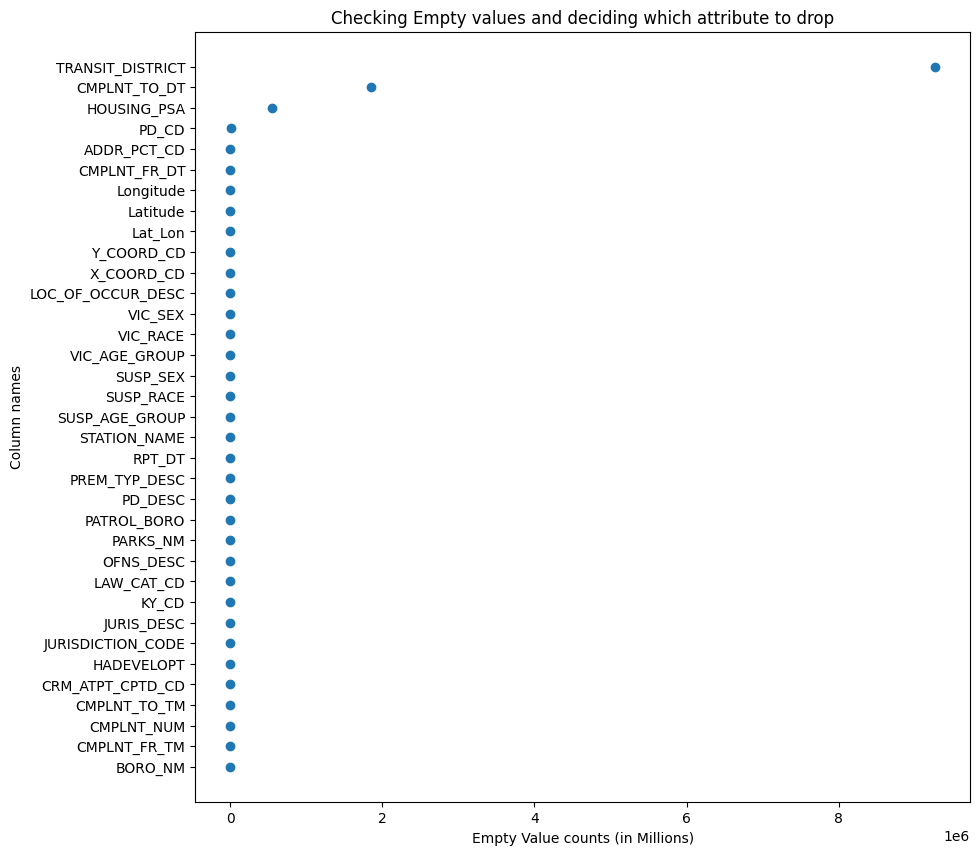

In [ ]:
empty_vals=sorted(empty_vals)

plt.figure(figsize=(10, 10))
plt.title("Checking Empty values and deciding which attribute to drop")
plt.ylabel("Column names")
plt.xlabel("Empty Value counts (in Millions)")
plt.scatter(empty_vals, cols_sort)

Checking which top dates are shady

In [ ]:
top_dates=profiles.column('CMPLNT_FR_DT').get('topValues')

<BarContainer object of 10 artists>

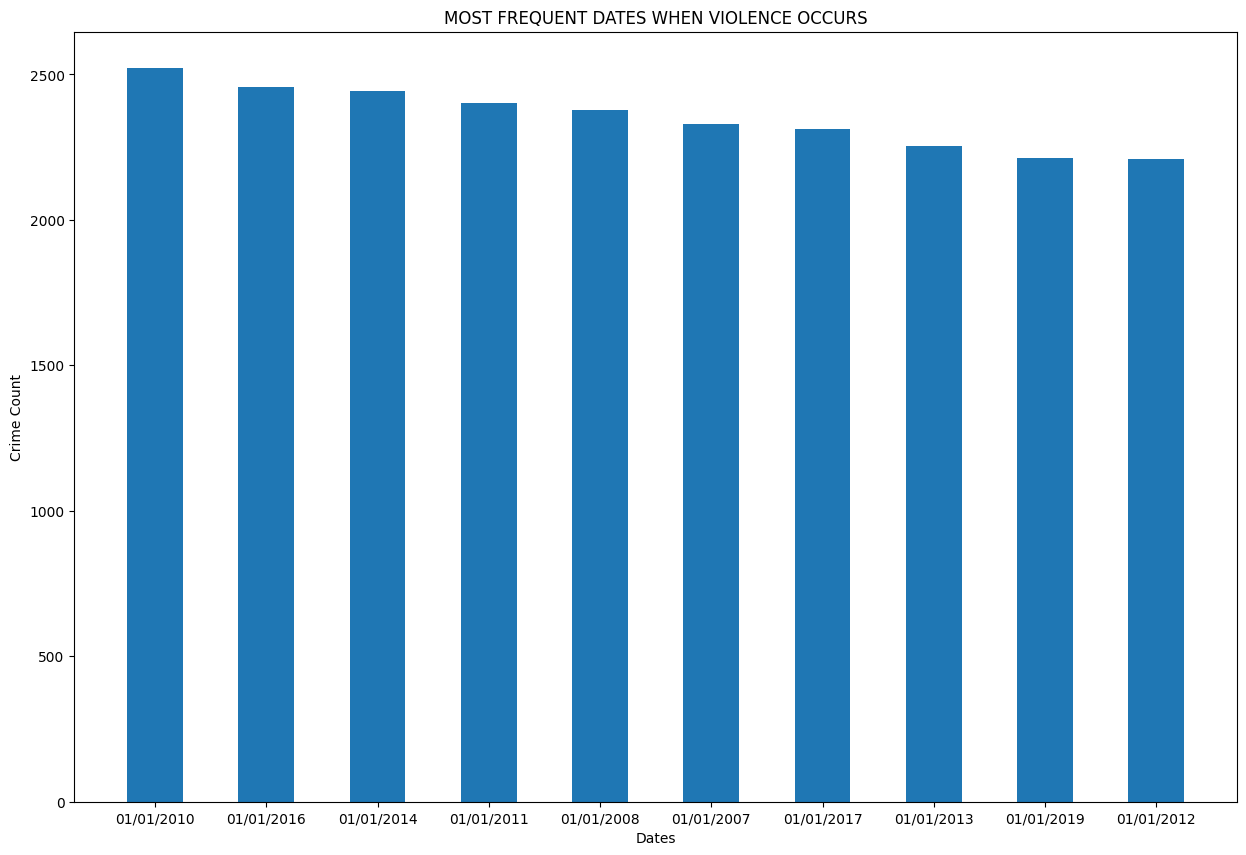

In [ ]:
x=[]
y=[]
for i,j in top_dates:
  x.append(i)
  y.append(j)

plt.figure(figsize=(15, 10))
plt.xlabel("Dates")
plt.ylabel("Crime Count")
plt.title('MOST FREQUENT DATES WHEN VIOLENCE OCCURS')
plt.bar(x, y, width=0.5)


Lets check what time in a day are shady

In [ ]:
top_time=profiles.column('CMPLNT_FR_TM').get('topValues')

<BarContainer object of 10 artists>

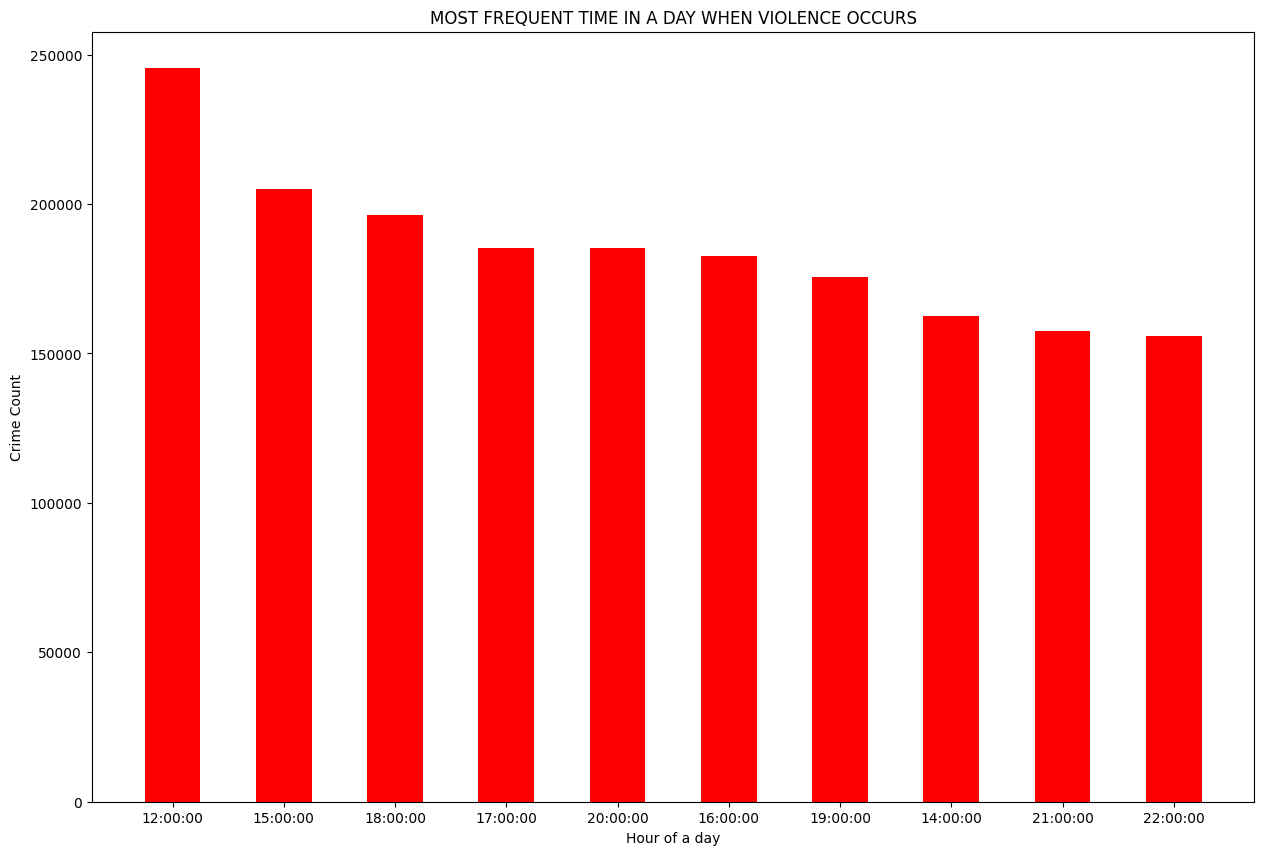

In [ ]:
x=[]
y=[]
for i,j in top_time:
  x.append(i)
  y.append(j)

plt.figure(figsize=(15, 10))
plt.xlabel("Hour of a day")
plt.ylabel("Crime Count")
plt.title('MOST FREQUENT TIME IN A DAY WHEN VIOLENCE OCCURS')
plt.bar(x, y, width=0.5, color=['r'])

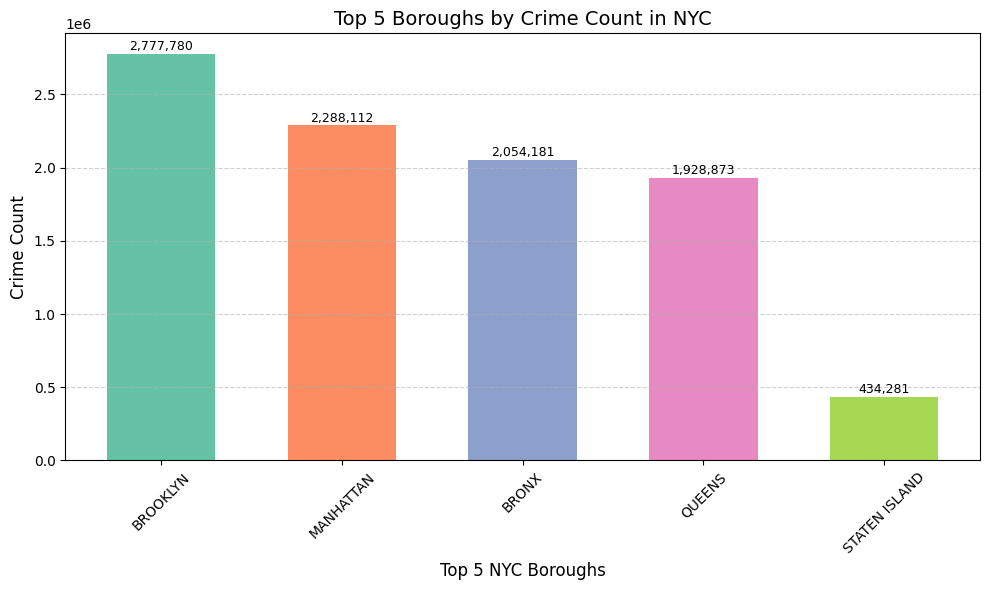

In [ ]:
top_boro = profiles.column('BORO_NM').get('topValues')

x = []
y = []
for borough, count in top_boro:
    x.append(borough)
    y.append(count)

# Sort and keep only top 5
x, y = zip(*sorted(zip(x, y), key=lambda pair: pair[1], reverse=True)[:5])

# Set up color palette
palette = sns.color_palette("Set2", len(x))

# Plot
plt.figure(figsize=(10, 6))
bars = plt.bar(x, y, width=0.6, color=palette)

# Add labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 5000, f'{height:,}', ha='center', va='bottom', fontsize=9)

# Customize chart
plt.xlabel("Top 5 NYC Boroughs", fontsize=12)
plt.ylabel("Crime Count", fontsize=12)
plt.title("Top 5 Boroughs by Crime Count in NYC", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

LETS Check the max violene occuring places at NYC using max points from profiling.

In [ ]:
lats=profiles.column('Latitude').get('topValues')
lgts=profiles.column('Longitude').get('topValues')

lats_=[float(i[0]) for i in lats]
lgts_=[float(i[0]) for i in lgts]

latcount=[i[1] for i in lats]
longcount=[i[1] for i in lats]

f_lats=[]
f_long=[]
for c in range(len(latcount)):
  temp1=[lats_[c]]*latcount[c]
  temp2=[lgts_[c]]*longcount[c]
  f_lats+=temp1
  f_long+=temp2

### **NOTE: To run this module, please uncomment the code, place your nyc census tract shape files (along with requirements) in the required location and use them. You will get the requirements along with the shp file when you download the data from this link below:**

You can find the shape files from : https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm

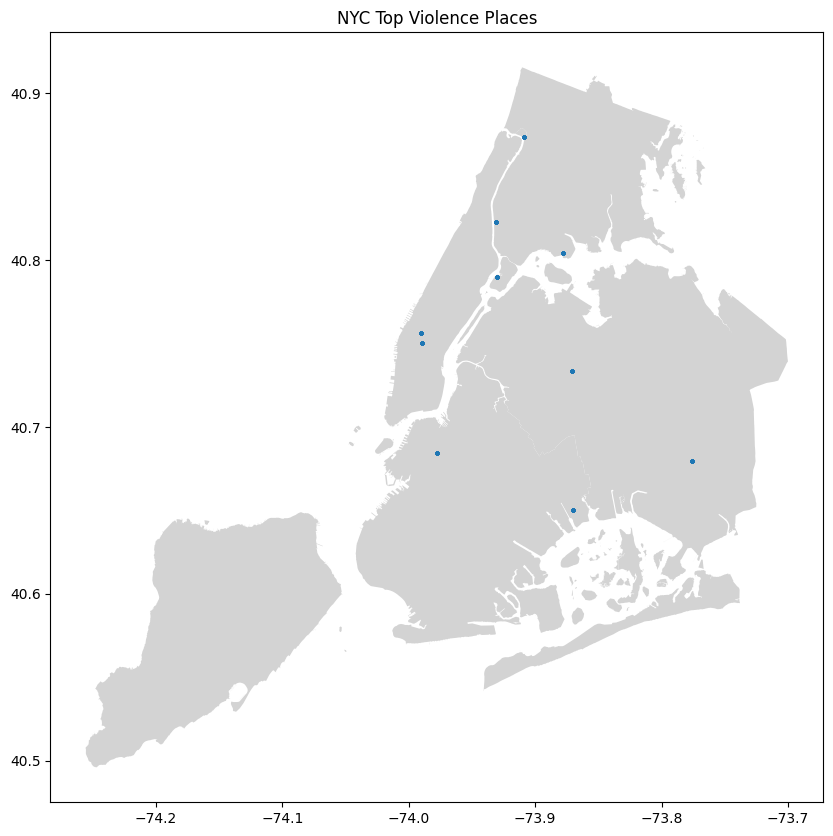

In [ ]:
# Step 1: Coordinates DataFrame
purified_dataset = pd.DataFrame()
purified_dataset['Latitude'] = f_lats
purified_dataset['Longitude'] = f_long

# Step 2: NYC Shapefile
NYC_map = gpd.read_file('/content/nybb.shp')

# Step 3: Coordinate system
crs = "EPSG:4326"

# Step 4: Remove missing coordinates
valid_coords = purified_dataset.dropna(subset=['Longitude', 'Latitude'])

# Step 5: Create Point geometries
geometry = [Point(xy) for xy in zip(valid_coords['Longitude'], valid_coords['Latitude'])]

# Step 6: GeoDataFrame
geo_df = gpd.GeoDataFrame(valid_coords, geometry=geometry, crs=crs)

# Step 7: Plot
fig, ax = plt.subplots(figsize=(10, 10))
NYC_map.to_crs(epsg=4326).plot(ax=ax, color='lightgrey')
geo_df.plot(ax=ax, alpha=0.1, markersize=5)
ax.set_title('NYC Top Violence Places')
plt.show()

In [ ]:
# Make sure df_spark exists and has the column 'OFNS_DESC'
top_offenses = df_spark.groupBy("OFNS_DESC") \
    .count() \
    .orderBy("count", ascending=False) \
    .limit(10) \
    .toPandas()

<ipython-input-41-0cfbcdb592b5>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y="OFNS_DESC", x="count", data=top_offenses, palette="rocket")


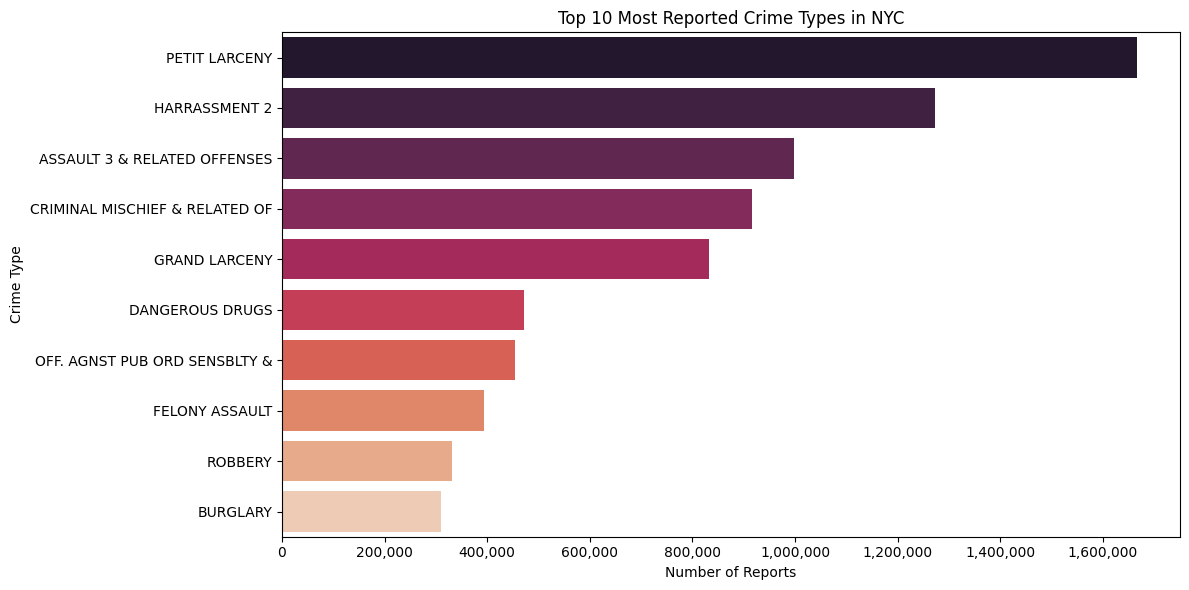

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(y="OFNS_DESC", x="count", data=top_offenses, palette="rocket")
plt.xlabel("Number of Reports")
plt.ylabel("Crime Type")
plt.title("Top 10 Most Reported Crime Types in NYC")

# Fix number formatting
plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{int(x):,}'))

plt.tight_layout()
plt.show()

<ipython-input-39-71ab4a436071>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="ADDR_PCT_CD", y="count", data=precinct_data, palette="viridis")


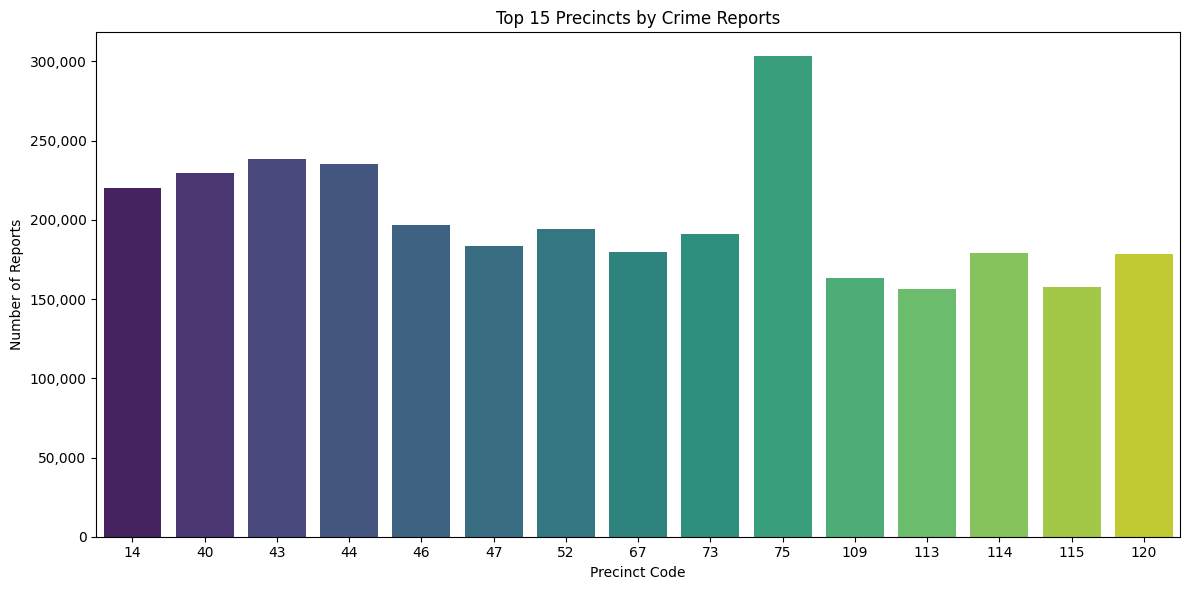

In [ ]:
precinct_data = df_spark.groupBy("ADDR_PCT_CD").count().orderBy("count", ascending=False).limit(15).toPandas()

plt.figure(figsize=(12, 6))
sns.barplot(x="ADDR_PCT_CD", y="count", data=precinct_data, palette="viridis")
plt.title("Top 15 Precincts by Crime Reports")
plt.xlabel("Precinct Code")
plt.ylabel("Number of Reports")

# Format y-axis
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{int(x):,}'))

plt.tight_layout()
plt.show()

<ipython-input-46-d581bcc7aa56>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="VIC_AGE_GROUP", y="count", data=age_group, palette="coolwarm")


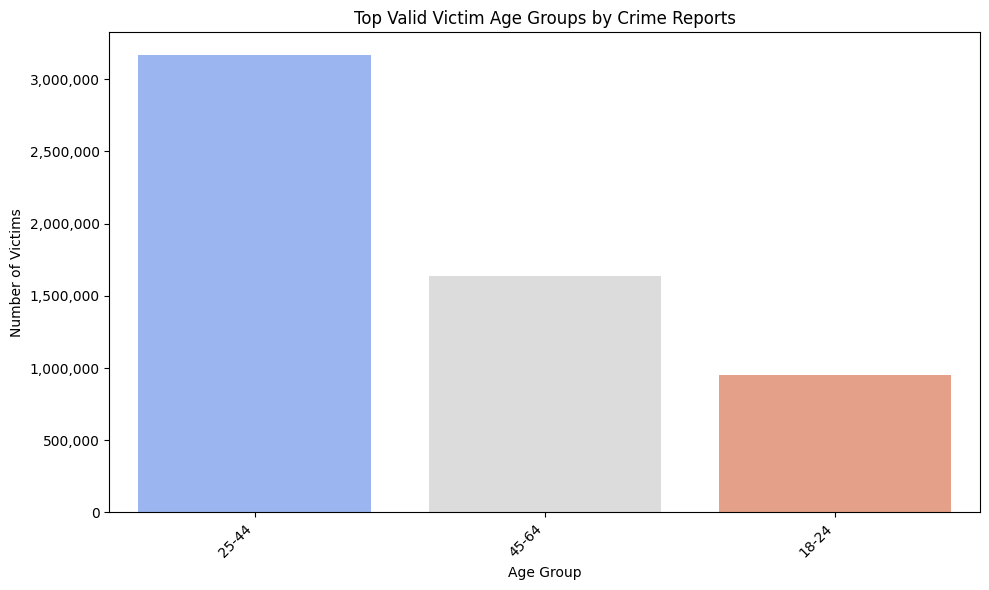

In [ ]:
# Clean whitespace
df_cleaned = df_spark.withColumn("VIC_AGE_GROUP", trim(col("VIC_AGE_GROUP")))

# Keep only valid patterns like '18-24', '25-44', etc.
df_valid_age = df_cleaned.filter(regexp_extract("VIC_AGE_GROUP", r"^\d{1,2}-\d{1,2}$", 0) != "")

# Get top 8 valid age groups
age_group = df_valid_age.groupBy("VIC_AGE_GROUP").count().orderBy("count", ascending=False).limit(8).toPandas()

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x="VIC_AGE_GROUP", y="count", data=age_group, palette="coolwarm")
plt.title("Top Valid Victim Age Groups by Crime Reports")
plt.xlabel("Age Group")
plt.ylabel("Number of Victims")
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

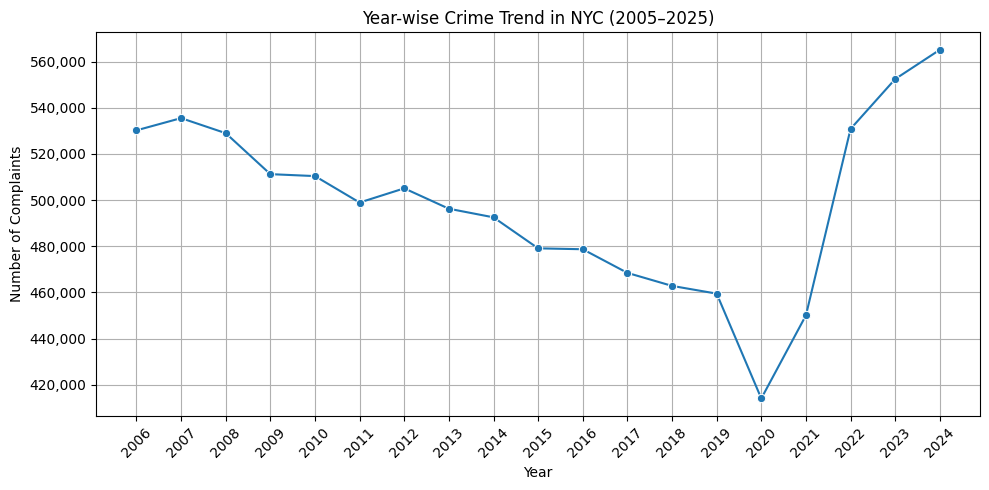

In [ ]:
# Parse string column to proper date
df_dated = df_spark.withColumn("parsed_date", to_date("CMPLNT_FR_DT", "MM/dd/yyyy"))

# Extract year from the parsed date
df_yearly = df_dated.withColumn("year", year("parsed_date"))

# Group and convert to pandas
yearly_data = df_yearly.groupBy("year").count().orderBy("year").toPandas()
yearly_data = yearly_data.dropna()

yearly_data = yearly_data[(yearly_data["year"] >= 2006) & (yearly_data["year"] <= 2025)]
yearly_data["year"] = yearly_data["year"].astype(int)

plt.figure(figsize=(10, 5))
sns.lineplot(x="year", y="count", data=yearly_data, marker='o')
plt.title("Year-wise Crime Trend in NYC (2005–2025)")
plt.xlabel("Year")
plt.ylabel("Number of Complaints")

# Format y-axis and x-axis
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.xticks(ticks=yearly_data["year"], labels=yearly_data["year"], rotation=45)

plt.grid(True)
plt.tight_layout()
plt.show()

# 1. We can consider the following columns as our area of interest:

1. CMPLNT_NUM
Randomly generated persistent ID for each complaint
2. CMPLNT_FR_DT
Exact date of occurrence for the reported event
3. CMPLNT_FR_TM
Exact time of occurrence for the reported event
4. ADDR_PCT_CD
The precinct in which the incident occurred
5. KY_CD
Three digit offense classification code
6. LAW_CAT_CD
Level of offense: felony, misdemeanor, violation
7. BORO_NM
The name of the borough in which the incident occurred
8. PREM_TYP_DESC
Specific description of premises; grocery store, residence, street, etc.
9. VIC_AGE_GROUP
Victim’s Age Group
10. VIC_RACE
Victim’s Race Description
11. VIC_SEX
Victim’s Sex Description
12. Latitude
13. Longitude
14. SUSP_AGE_GROUP
Suspect’s Age Group
15. SUSP_RACE
Suspect’s Race Description
16. SUSP_SEX
Suspect’s Sex Description
17. JURISDICTION_CODE
18. PATROL_BORO
19. PD_CD
20. HOUSING_PSA

In [ ]:
interested_columns_1=['CMPLNT_NUM','CMPLNT_FR_DT','CMPLNT_FR_TM', 'ADDR_PCT_CD', 'KY_CD', 'LAW_CAT_CD', 'LAW_CAT_CD', 'BORO_NM', 'PREM_TYP_DESC', 'VIC_AGE_GROUP',
           'VIC_RACE', 'VIC_SEX', 'Latitude', 'Longitude', 'SUSP_AGE_GROUP', 'SUSP_RACE', 'SUSP_SEX', 'JURISDICTION_CODE', 'PATROL_BORO', 'PD_CD','HOUSING_PSA']
df_spark=get_area_of_interest(df_spark, interested_columns_1)

## b. Lets pass the dataset through the preprocessing pipeline

In [ ]:
df_temp=df_spark.rdd

In [ ]:
df_temp.take(1)

[Row(CMPLNT_NUM='39468181', CMPLNT_FR_DT='02/20/2008', CMPLNT_FR_TM='07:00:00', ADDR_PCT_CD=88, KY_CD=107, LAW_CAT_CD='FELONY', LAW_CAT_CD='FELONY', BORO_NM='BROOKLYN', PREM_TYP_DESC='RESIDENCE - APT. HOUSE', VIC_AGE_GROUP='25-44', VIC_RACE='WHITE', VIC_SEX='F', Latitude=40.692464, Longitude=-73.972708, SUSP_AGE_GROUP='(null)', SUSP_RACE='UNKNOWN', SUSP_SEX='(null)', JURISDICTION_CODE=0, PATROL_BORO='PATROL BORO BKLYN NORTH', PD_CD=221, HOUSING_PSA='(null)')]

## 1. Lets work on time related columns

Similarly, lets check for the time as well. Here we must have time between
the standard 24 hours.

## 2. Lets work on date related columns

As the dataset is for the data from 2006 to 2025, we can see that there is data from unknown format of "1010-05-14" to the year 2025. We need to clean this. Over here, we remove the null values where the complaint date is <2006.

**NOTE: For the date check module, make sure to send the correct format as the second hyper parameter. Here it is mm/dd/yyyy format for the current dataset**

In [ ]:
df_temp_=df_temp.map(lambda x:(x, valid_time_check(x[2]))).filter(lambda x: x[1]==True)
df_temp=df_temp_.map(lambda x: x[0])

#filter the dates with proper format for Column-2 (CMPLNT_FR_DT)
df_temp_=df_temp.map(lambda x:(x, valid_date_check(x[1], 'mm/dd/yyyy'))).filter(lambda x: x[1]==True)
df_temp=df_temp_.map(lambda x: x[0])

## 4.1 Lets refine the Age Group and Race columns

The module works for only those columns whose column names are passed

## 4.2 Lets refine the Gender, Race Columns for suspects and victims

The module works for only those columns whose column names are passed

In [ ]:
# #as this code requires the pyspark dataframe(Not the rdd)
df_temp=df_temp.toDF(schema=df_spark.schema)
df_temp=refine_age_group_race(df_temp, "VIC_AGE_GROUP", "SUSP_AGE_GROUP", 'SUSP_RACE', 'VIC_RACE')
df_temp=refine_sex_gender_impute(df_temp, None, 'SUSP_SEX', None, 'VIC_SEX')

## 4.3 Lets refine the level of offense column

In [ ]:
#Filtering offence
df_temp=df_temp.rdd
df_temp_=df_temp.map(lambda x:(x, level_of_offence_check(x[5]))).filter(lambda x: x[1]==True)
df_temp=df_temp_.map(lambda x: x[0])

# 5 KY_CD, PATROL_BORO, HOUSING_PSA, PD_CD, PREM_TYP_DESC refining




In [ ]:
df_temp_=df_temp.map(lambda x:(x, KY_CD_Check(x[3]))).filter(lambda x: x[1]==True)
df_temp=df_temp_.map(lambda x: x[0])

df_temp_=df_temp.map(lambda x:(x, hpsa_check(x[-1]))).filter(lambda x: x[1]==True)
df_temp=df_temp_.map(lambda x: x[0])

df_temp_=df_temp.map(lambda x:(x, prem_check(x[8]))).filter(lambda x: x[1]==True)
df_temp=df_temp_.map(lambda x: x[0])

In [ ]:
df_temp_=df_temp.map(lambda x:(x, pd_cd_check(x[-2]))).filter(lambda x: x[1]==True)
df_temp=df_temp_.map(lambda x: x[0])

# 6. Geospacial Attributes Imputation:

## 6.a: Precinct, Jurisdiction Code:
  dropping the null values

  The module works for only those columns whose column names are passed along with the df

In [ ]:
df_temp_=df_temp.map(lambda x:(x, valid_precinct_check(x[3]))).filter(lambda x: x[1]==True)
df_temp=df_temp_.map(lambda x: x[0])

df_temp_=df_temp.map(lambda x:(x, valid_jur_check(x[-4]))).filter(lambda x: x[1]==True)
df_temp=df_temp_.map(lambda x: x[0])

## 6.b Reverse Geocoding the boroughs using latitudes and longitudes.

In [ ]:
#Filtering the latitude and longitude that is invalid or is outside NYC
df_temp_=df_temp.map(lambda x:(x, to_check_lat(x[12]))).filter(lambda x: x[1]==True)
df_temp=df_temp_.map(lambda x: x[0])

df_temp_=df_temp.map(lambda x:(x, to_check_long(x[13]))).filter(lambda x: x[1]==True)
df_temp=df_temp_.map(lambda x: x[0])

df_temp=df_temp.toDF(schema=df_spark.schema)

Lets profile the data now.

In [ ]:
pandasDF = df_spk.toPandas()
ds=stream(pandasDF)

#Creating profile of our dataset
profiles = ds.profile(default_profiler=DefaultColumnProfiler)
profiles.stats()

,total,empty,distinct,uniqueness,entropy
CMPLNT_NUM,6165,0,6165,1.000000,12.589885
CMPLNT_FR_DT,6165,0,3356,0.544363,11.516650
CMPLNT_FR_TM,6165,0,778,0.126196,7.912644
ADDR_PCT_CD,6165,0,77,0.012490,6.131651
KY_CD,6165,0,47,0.007624,4.213032
LAW_CAT_CD,6165,0,3,0.000487,1.360312
LAW_CAT_CD,6165,0,3,0.000487,1.360312
BORO_NM,6165,0,5,0.000811,2.163910
PREM_TYP_DESC,6165,0,67,0.010868,3.543163
VIC_AGE_GROUP,6165,0,6,0.000973,2.219383


# For all the other datasets, lets calculate the precision and recall values

Precision= TP/Selected values


Recall=TP/relevent values

NOTE: THE VALUES ARE TAKEN USING THE PROFILING STATS CREATED IN THE INDIVIDUAL NOTEBOOKS

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def plotRecPrec(prec, rec, cols, title):
  plt.figure(figsize=(10, 8))
  bar1=plt.bar(cols, rec)
  bar2=plt.bar(cols, prec, width=0.2)
  plt.title('Recall and precision values for '+title)
  plt.xlabel("precision and recall")
  plt.ylabel("value")
  plt.legend([bar1, bar2], ['Recall', "Precision"])


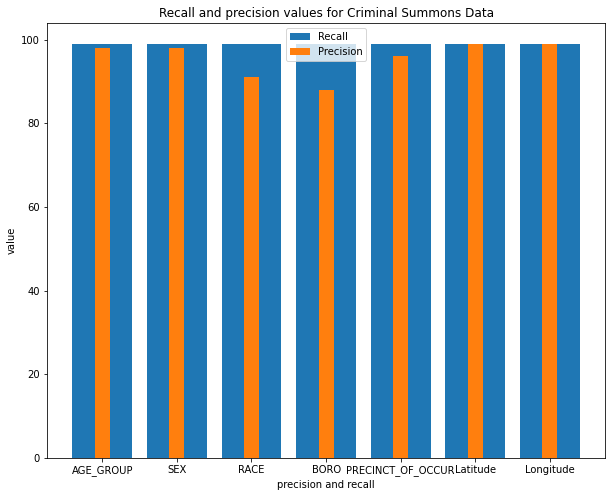

In [ ]:
#criminal dataset:
interested_columns_1=['AGE_GROUP', 'SEX', 'RACE', 'BORO', 'PRECINCT_OF_OCCUR', 'Latitude', 'Longitude']
recall=[99, 99, 99, 99, 99, 99, 99]
precision=[98, 98, 91, 88, 96, 99, 99]

plotRecPrec(precision, recall, interested_columns_1, 'Criminal Summons Data')

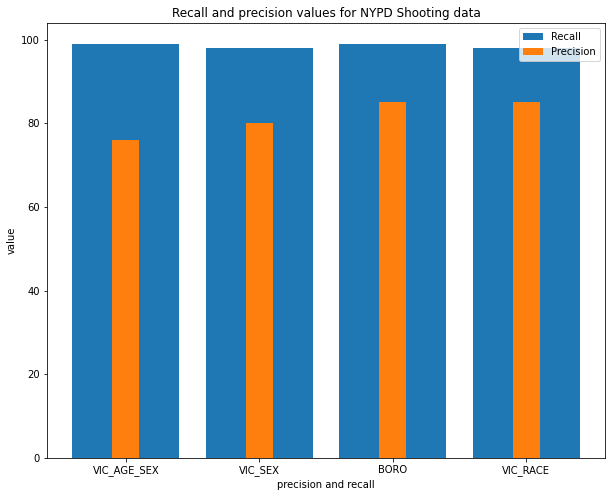

In [ ]:
columns=['VIC_AGE_SEX', 'VIC_SEX', "BORO", 'VIC_RACE']
prec=[76, 80, 85, 85]
rec=[99, 98, 99, 98]
plotRecPrec(prec, rec, columns, "NYPD Shooting data")

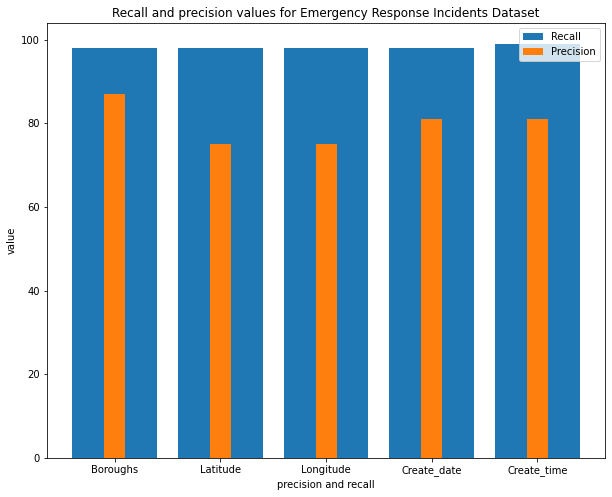

In [ ]:
columns=['Boroughs', 'Latitude', 'Longitude', 'Create_date', 'Create_time']
precision=[87, 75, 75, 81, 81]
recall=[98, 98, 98, 98, 99]
plotRecPrec(precision, recall, columns, 'Emergency Response Incidents Dataset')